## Training for distilbert transformer
Follow this tutorial :https://huggingface.co/transformers/custom_datasets.html

In [1]:
import pandas as pd 
from transformers import DistilBertTokenizerFast, Trainer, TrainingArguments, DistilBertForSequenceClassification, AdamW, DistilBertConfig
from sklearn.metrics import precision_score,classification_report,confusion_matrix,roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch.nn.functional import softmax
from torch.nn import CrossEntropyLoss
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformer_utils import customDataset
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np


In [2]:
train_file = "../data/label_data.csv"
test_file = "../data/label_data.csv"
LABEL_COL = "class"
TEXT_COL = "comment"

## Utilities functions

In [3]:
def read_data(fname:str, lower_case: bool=False) ->pd.DataFrame:
        """
        This function will read the textfiles.

        fname will be out of new_train_data.csv, unlabeled_data.csv and test_data.txt

        """
        try:
            df = pd.read_csv(fname, encoding = "UTF-8", usecols = ["class","comment"])
            df[LABEL_COL]= df[LABEL_COL].replace({"negative":0, "neutral":1, "positive":2})
            if lower_case:
                df[TEXT_COL]= df[TEXT_COL].str.lower()

            return df
        except (FileNotFoundError,PermissionError):

            print("No files found. Check the data directory for files.")

In [4]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall}

## Load pretrained models and tokenizer

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
device

device(type='cuda', index=0)

## Fine-tuning on custom data with basic transformer parameters

In [6]:
train_df = read_data(train_file, lower_case = True)
labels = train_df[LABEL_COL].values

In [7]:
train_df["class"].value_counts(normalize = True)

2    0.778333
0    0.120000
1    0.101667
Name: class, dtype: float64

In [8]:
train_df["class"]

0      2
1      1
2      2
3      2
4      1
      ..
595    2
596    0
597    2
598    2
599    2
Name: class, Length: 600, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_df[TEXT_COL].values, labels, test_size=.2,random_state = 42)

In [10]:
train_texts= train_texts.tolist()
val_texts = val_texts.tolist()
# train_labels = train_labels.values
# val_labels = val_labels.values

In [11]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels = 3)



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [12]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

## Tokenize the training and test text 


In [13]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
#test_encodings = tokenizer(test_texts, truncation=True, padding=True)

## Turn the tokenized encodings and labels to Dataset obj in pytorch


In [14]:
train_dataset = customDataset(train_encodings, train_labels)
val_dataset = customDataset(val_encodings,val_labels)

## Pass dataset to dataloader to help us batch our dataset 

In [15]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True)

## Train with trainer

In [ ]:
# training argument to be defined outside of class? 
# for together with arg_parse? 
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=50,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps = 20,
    no_cuda = True
    
)

In [ ]:
epochs=5        # total # of training epochs
per_device_train_batch_size=16  # batch size per device during training
per_device_eval_batch_size=64   # batch size for evaluation
warmup_steps=50                # number of warmup steps for learning rate scheduler
weight_decay=0.05

In [ ]:
# trainer = Trainer(model = model,
#                    args = training_args,
#                    train_dataset = train_dataset, 
#                    eval_dataset = val_dataset,
#                     compute_metrics = compute_metrics)
# trainer.train()

## Custom training in pytorch 

In [16]:
def train_model(model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels = 3),
                train_loader= train_loader, 
                val_loader= val_loader,
                optimizer = AdamW(model.parameters(), lr = 5e-5),
                num_epochs = 5,
                criterion = CrossEntropyLoss(),
                writer = SummaryWriter("logs/distilbert/baselines")):

    # for training data set 
    running_loss = 0 
    running_correct = 0

    # number of steps within each epoch for training loader
    training_iterations = len(train_loader)

    # for val data set 
    val_running_loss = 0 
    val_running_correct = 0

    # number of steps within each epoch for val laoder
    val_iterations = len(val_loader)

    # for each epoch
    for epoch in range(num_epochs):

        train_pred = np.array([])
        val_pred = np.array([])

        # train 
        # set the model to training mode (as oppose to evaluation mode)
        model.train()


        for step, batch in enumerate(train_loader):

            batch["input_ids"].to(device)
            batch["attention_mask"].to(device)
            batch["labels"].to(device)  

            # zero grads 

            optimizer.zero_grad()

            # forward pass 
            outputs = model(batch["input_ids"],batch["attention_mask"], labels = batch["labels"])

            # get logits from model output
            logits = outputs["logits"]
            # logits must be float64, so need to use .double()
            # labels must be long
            
            loss = criterion(logits.double(),batch["labels"])
            
            # backward pass
            loss.backward()
            # update weights 

            optimizer.step()

            # update learning rate
            running_loss += loss.item()

            predicted_labels = torch.argmax(logits, dim = 1)

            # only capture the prediction of the last step in last epoch
            train_pred = np.append(train_pred,predicted_labels.cpu().numpy())
            precision_avg_score= precision_score(batch["labels"], predicted_labels, average = "macro")

            running_correct += precision_avg_score
    #         if (step + 1)% 10 == 0: 
    #             print(f"Epoch: {epoch+1}, step {step+1}/{num_examples}, Loss: {loss.item()}, running_loss: {running_loss/100},Acc: {acc}")

    #==============================================
    # validation set
    #==============================================
        model.eval()


        for step, val_batch in enumerate(val_loader):

            val_batch["input_ids"].to(device)
            val_batch["attention_mask"].to(device)
            val_batch["labels"].to(device)  

            # zero grads 

            optimizer.zero_grad()

            with torch.no_grad():

                val_outputs = model(val_batch["input_ids"],val_batch["attention_mask"], labels = val_batch["labels"])
                # get loss 

                # get logist from model output
                val_logits = val_outputs["logits"]

                val_loss = criterion(val_logits.double(),val_batch["labels"])

                val_predicted_labels = torch.argmax(val_logits, dim = 1)

                # only capture the prediction of the last step in last epoch
                val_pred = np.append(val_pred,val_predicted_labels.cpu().numpy())
                val_running_loss += val_loss

                val_precision_avg_score= precision_score(val_batch["labels"], val_predicted_labels, average = "macro")

                val_running_correct += val_precision_avg_score
        # accumulate the loss and accuracy for each epoch 

        print(f"Epoch: {epoch+1},train_Loss: {running_loss/training_iterations},train_acc: {running_correct/training_iterations}")
        print(f"Epoch: {epoch+1},val_Loss: {val_running_loss/val_iterations},val_acc: {val_running_correct/val_iterations}")
        writer.add_scalars("Loss curve", {"train loss":running_loss/training_iterations,"val loss":val_running_loss/val_iterations}, global_step = epoch + 1)
        writer.add_scalars("Precision Score curve",{"train precision":running_correct/training_iterations,"val precision":val_running_correct/val_iterations}, global_step = epoch + 1)


        running_loss = 0 
        running_correct = 0

        val_running_loss = 0 
        val_running_correct = 0

    writer.close()


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [18]:
train_model(model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels = 3),
            train_loader= train_loader, 
            val_loader= val_loader,
            optimizer= AdamW(model.parameters(), lr = 5e-5),
            num_epochs = 1,
            criterion = CrossEntropyLoss(),
            writer = SummaryWriter("logs/distilbert/test"))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Epoch: 1,train_Loss: 1.0977797773709301,train_acc: 0.29208353375020046
Epoch: 1,val_Loss: 1.0889577711979592,val_acc: 0.32796601546601545


In [ ]:
model.save_pretrained("../models/distilbert/test")

## Seems to be overfitting, increase the weight decay for adamW for regularization 
Default weight_decay = 0.01

Try: weight_decay = 0.08 

weight_decay = 0.5

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels = 3)


In [ ]:
train_model(model,
            train_loader, 
            val_loader,
            optimizer= AdamW(model.parameters(), lr = 5e-5, weight_decay = 0.08),
            num_epochs = 20,
            criterion = CrossEntropyLoss(),
            writer = SummaryWriter("logs/distilbert/weight_decay=0.08"))

In [ ]:
model.save_pretrained("../models/distilbert/weight_decay=0.08")

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels = 3)


In [ ]:
train_model(model,
            train_loader, 
            val_loader,
            optimizer= AdamW(model.parameters(), lr = 5e-5, weight_decay = 0.5),
            num_epochs = 15,
            criterion = CrossEntropyLoss(),
            writer = SummaryWriter("logs/distilbert/weight_decay=0.5"))

In [ ]:
model.save_pretrained("../models/distilbert/weight_decay=0.5")

## Because the dataset is imbalanced, it is not doing so well for minority classes.

One way to improve performance for imbalanced dataset is to adjust weights for the classes during model training. 

Add in the adjusted class weights into the cross entropy loss function during model training. 

In [ ]:
train_df["class"].value_counts()

In [ ]:
no_samples_class_2, no_samples_class_0, no_samples_class_1= train_df["class"].value_counts().values

## Formula for adjusting weights

In [ ]:
def cal_class_weights(no_samples_for_class, total_samples, no_of_class):

    class_weight = total_samples/(no_of_class * no_samples_for_class)
    return class_weight

In [ ]:
weights_class_2 = cal_class_weights(no_samples_class_2,train_df.shape[0], 3)

In [ ]:
weights_class_0 = cal_class_weights(no_samples_class_0,train_df.shape[0], 3)

In [ ]:
weights_class_1 = cal_class_weights(no_samples_class_1,train_df.shape[0], 3)

## Weights passed to cross entropy loss will be inn order from 0 to num_classes

In [ ]:
weights = [weights_class_0,weights_class_1,weights_class_2] 
tensor_weights= torch.tensor(weights)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels = 3)



tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [ ]:
train_model(model,
            train_loader, 
            val_loader,
            optimizer= AdamW(model.parameters(), lr = 5e-5),
            num_epochs = 20,
            criterion = CrossEntropyLoss(weight = tensor_weights),
            writer = SummaryWriter("logs/distilbert/adjust_weights"))

In [ ]:
model.save_pretrained("../models/distilbert/adjust_weights")

## Combining weight decay and adjusting weights for imbalanced class

In [ ]:
train_model(model,
            train_loader, 
            val_loader,
            optimizer= AdamW(model.parameters(), lr = 5e-5,weight_decay = 0.5),
            num_epochs = 15,
            criterion = CrossEntropyLoss(weight = tensor_weights),
            writer = SummaryWriter("logs/distilbert/decay_0_5_adjust_weights"))

In [ ]:
model.save_pretrained("../models/distilbert/adjust_weights_weight_decay=0.5")

In [23]:
def get_prediction(model= model,
                  test_loader= val_loader):

    prediction = np.array([])
    true = np.array([])
    probability = np.array([])
    for step, val_batch in enumerate(test_loader):

        val_batch["input_ids"].to(device)
        val_batch["attention_mask"].to(device)
        val_batch["labels"].to(device)  

        # zero grads 

        with torch.no_grad():

            outputs = model(val_batch["input_ids"],val_batch["attention_mask"], labels = val_batch["labels"])
            # get loss 
            loss = outputs["loss"]

            # get logist from model output
            logits = outputs["logits"]
            
            #s
            class_proba = softmax(logits,dim = 1)
            predicted_labels = torch.argmax(logits, dim = 1)
            
            probability = np.append(probability, class_proba.cpu().numpy())

            prediction = np.append(prediction,predicted_labels.cpu().numpy())
            true= np.append(true,val_batch["labels"])

        #print(predicted_labels.cpu().numpy())
    return true, prediction,probability

In [24]:
def get_classification_report(model = model,
                              test_loader =val_loader):
    
    true, prediction,probability = get_prediction(model = model ,test_loader =val_loader)
    print(classification_report(true,prediction))

In [ ]:
print("no_custom_train")
get_classification_report(model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels = 3),
                     test_loader = val_loader)

In [ ]:
print("overfit")
print(classification_report(overfit_true, overfit_pred))

In [ ]:
print("Adjust_class_weights")
get_classification_report(model = DistilBertForSequenceClassification.from_pretrained("../models/distilbert/adjust_weights"),
                     test_loader = val_loader)

In [ ]:
print("baseline")
get_classification_report(model = DistilBertForSequenceClassification.from_pretrained("../models/distilbert/baseline"),
                     test_loader = val_loader)

In [ ]:
print("decay_point_5")
get_classification_report(model = DistilBertForSequenceClassification.from_pretrained("../models/distilbert/weight_decay=0.5"),
                     test_loader = val_loader)

In [ ]:
print("decay_point_zero_8")
get_classification_report(model = DistilBertForSequenceClassification.from_pretrained("../models/distilbert/weight_decay=0.08"),
                     test_loader = val_loader)

In [ ]:
print("decay and adjust weights")

get_classification_report(model = DistilBertForSequenceClassification.from_pretrained("../models/distilbert/adjust_weights_weight_decay=0.5"),
                     test_loader = val_loader)


In [ ]:
def get_precision_score(model= model,
                      test_loader= val_loader):
    true, prediction,probability = get_prediction(model= model,
                      test_loader= val_loader)

    return precision_score(true, predicted, average = "macro")

In [ ]:
def model_sort_precision_scores(model_list):
    
    """
    model_list: list of models
    """
    model_name = [model.name for model in model_list]
    precision_score = [get_precision_score(model = DistilBertForSequenceClassification.from_pretrained(model),
                test_loader = val_loader) for model in model_list]
    df_score = pd.DataFrame(zip(model_name,precision_score),columns = ["model_name","precision_score"])
    df_score.sort_values(by= "precision_score",ascending = False,inplace = True)
    return df_score


In [ ]:
def plot_confusion_matrix(model= model,
                  test_loader= val_loader):
    true, prediction,probability = get_prediction(model= model,
                      test_loader= val_loader)
    matrix = confusion_matrix(true, prediction,normalize = "true")
    return matrix 

## Grab the directory of all the models within distilbert 

In [ ]:
distilbert_models  = Path("../models/distilbert")

In [ ]:
distilbert_model_list = [model for model in distilbert_models.iterdir() if model.is_dir()]

## Sort the trained models by their macro precision scores

In [ ]:
model_sort_precision_scores(distilbert_model_list)

In [ ]:
fig,ax=plt.subplots(3,2,figsize = (12,10))
# for model_path in subdir:
#     i = 0
#     j = 0
#     cm = plot_confusion_matrix(model = str(model_path),
#                          test_loader = val_loader)
sns.heatmap(plot_confusion_matrix(model = DistilBertForSequenceClassification.from_pretrained("../models/distilbert/adjust_weights"),
            test_loader = val_loader), cmap="YlGnBu",annot = True,ax = ax[0,0])
sns.heatmap(plot_confusion_matrix(model = DistilBertForSequenceClassification.from_pretrained("../models/distilbert/adjust_weights_weight_decay=0.5"),
            test_loader = val_loader), cmap="YlGnBu",annot = True,ax = ax[0,1])
sns.heatmap(plot_confusion_matrix(model = DistilBertForSequenceClassification.from_pretrained("../models/distilbert/baseline"),
            test_loader = val_loader), cmap="YlGnBu",annot = True,ax = ax[1,0])
sns.heatmap(plot_confusion_matrix(model = DistilBertForSequenceClassification.from_pretrained("../models/distilbert/model_config"),
            test_loader = val_loader), cmap="YlGnBu",annot = True,ax = ax[1,1])
sns.heatmap(plot_confusion_matrix(model = DistilBertForSequenceClassification.from_pretrained("../models/distilbert/weight_decay=0.08"),
            test_loader = val_loader), cmap="YlGnBu",annot = True,ax = ax[2,0])
sns.heatmap(plot_confusion_matrix(model = DistilBertForSequenceClassification.from_pretrained("../models/distilbert/weight_decay=0.5"),
            test_loader = val_loader), cmap="YlGnBu",annot = True,ax = ax[2,1])

ax[0,0].set_title("adjust_weights")
ax[0,1].set_title("adjust_weights_weight_decay=0.5")
ax[1,0].set_title("baseline")
ax[1,1].set_title("model_config")
ax[2,0].set_title("weight_decay=0.08")
ax[2,1].set_title("weight_decay=0.5")



## Plotting the roc curve for classifier 

1) Compare roc plot between weight_decay = 0.5 and baseline 

In [21]:
def inputs_to_roc_curve(model = model,
                  test_loader = val_loader,
                    n_classes = 3):
    
    # compute roc curve and roc area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    
    true,predict,probability = get_prediction(model = model,
                         test_loader = val_loader)
    # true.shape = (n,) --> y_binarized_true.shape (n,n_classes)
    
    y_binarized_true = label_binarize(true, classes = list(range(n_classes)))
    # probability.shape = (n * n_classes) --> y_score.shape = (n,n_classes)
    y_score = probability.reshape(120,3)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_binarized_true[:,i],y_score[:,i])
        roc_auc[i] = auc(fpr[i],tpr[i])
    
    return fpr, tpr, roc_auc
    

In [52]:
print("weight decay 0.5")
print(get_classification_report(model = DistilBertForSequenceClassification.from_pretrained("../models/distilbert/weight_decay=0.5"),
                     test_loader = val_loader))

weight decay 0.5
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        19
         1.0       1.00      0.82      0.90        11
         2.0       0.99      1.00      0.99        90

    accuracy                           0.98       120
   macro avg       0.98      0.94      0.96       120
weighted avg       0.98      0.98      0.98       120

None


In [82]:
DistilBertForSequenceClassification.from_pretrained("../models/distilbert/baseline")

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [74]:
def plot_roc(row = 0, col = 0,
             data_class = 0,
             model= model, 
             test_loader = val_loader,
             n_classes = 3,
            model_name = "baseline"):
    fpr, tpr, roc_auc= inputs_to_roc_curve(model = model,
                          test_loader = val_loader,
                            n_classes = 3)
    lw = 2
    ax[row,col].plot(fpr[data_class], tpr[data_class],color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[data_class])
    ax[row,col].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    ax[row,col].set_xlim([0.0, 1.0])
    ax[row,col].set_ylim([0.0, 1.05])
    ax[row,col].set_xlabel('False Positive Rate')
    ax[row,col].set_ylabel('True Positive Rate')
    ax[row,col].set_title(f'{model_name} Class {data_class}')
    ax[row,col].legend(loc="lower right")

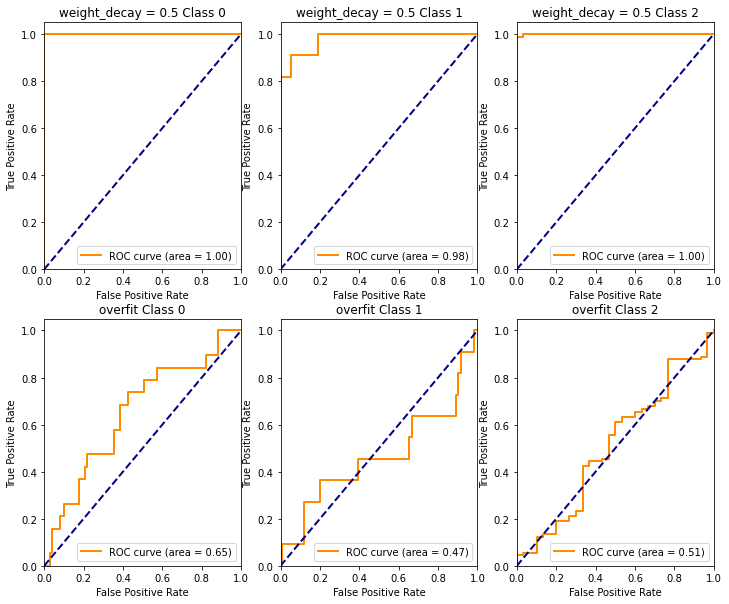

In [87]:
fig,ax=plt.subplots(2,3,figsize = (12,10))
plot_roc(row = 0, col = 0,
         data_class = 0,
         model= DistilBertForSequenceClassification.from_pretrained("../models/distilbert/weight_decay=0.5"), 
         test_loader = val_loader,
         n_classes = 3,
        model_name = "weight_decay = 0.5")
plot_roc(row = 0, col = 1,
         data_class = 1,
         model= DistilBertForSequenceClassification.from_pretrained("../models/distilbert/weight_decay=0.5"), 
         test_loader = val_loader,
         n_classes = 3,
        model_name = "weight_decay = 0.5")
plot_roc(row = 0, col = 2,
         data_class = 2,
         model= DistilBertForSequenceClassification.from_pretrained("../models/distilbert/weight_decay=0.5"), 
         test_loader = val_loader,
         n_classes = 3,
        model_name = "weight_decay = 0.5")

plot_roc(row = 1, col = 0,
         data_class = 0,
         model = DistilBertForSequenceClassification.from_pretrained("../models/distilbert/model_config"), 
         test_loader = val_loader,
         n_classes = 3,
         model_name = "overfit")

plot_roc(row = 1, col = 1,
         data_class = 1,
         model= DistilBertForSequenceClassification.from_pretrained("../models/distilbert/model_config"), 
         test_loader = val_loader,
         n_classes = 3,
         model_name = "overfit")

plot_roc(row = 1, col = 2,
         data_class = 2,
         model= DistilBertForSequenceClassification.from_pretrained("../models/distilbert/model_config"), 
         test_loader = val_loader,
         n_classes = 3,
         model_name = "overfit")